In [1]:
#import torch
import os, sys, re, time
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")

400675


In [2]:
import cv2
from ChromAn.src.file_io.data_organization import search_fovs_in_folders, Color_Usage
from ChromAn.src.segmentation_tools.cells import Align_Segmentation

In [3]:
import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation
from copy import copy

In [4]:
# Cellpose 
from cellpose import models

## Folders

In [5]:
# data_folder
data_folder = r'/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5'
# correction
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20230824-Merscope01'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    print(segmentation_save_folder)
    os.makedirs(segmentation_save_folder)
watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [6]:
# transpose with microscope
parameter_folder = r'/lab/weissman_imaging/puzheng/Softwares/Weissman_MERFISH_Scripts/merlin_parameters'
microscope_file = os.path.join(parameter_folder, 'microscope', 'merscope01_microscope.json')
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.107,
 'image_dimensions': [2304, 2304]}

In [7]:
# search folders
folders, fovs = search_fovs_in_folders(data_folder)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF5.csv')
color_usage_df = Color_Usage(color_usage_filename)

- searching in folder: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5
-- 13 folders, 291 fovs detected.
- load color_usage from file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/Analysis/color_usage_MF5.csv


In [8]:
# from color_usage, find dapi / polyt / fiducial
dapi_info = color_usage_df.get_dapi_info()[0]
polyt_info = color_usage_df.get_polyt_info()[0]
fiducial_channel = color_usage_df.get_fiducial_channel(color_usage_df)
print(dapi_info, polyt_info, fiducial_channel)

{'hyb': 'H0M1', 'channel': '405'} {'channel': '637', 'hyb': 'H12M13'} 477


# Run segmentation

In [9]:
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d
from merlin.analysis.segment import CellPoseSegment

In [10]:
from importlib import reload

In [19]:
import ChromAn
reload(ChromAn.src.file_io.dax_process)

<module 'ChromAn.src.file_io.dax_process' from '/lab/weissman_imaging/puzheng/Softwares/ChromAn/src/file_io/dax_process.py'>

In [23]:
for _fov_id, _fov_name in enumerate(fovs):

    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(seg_save_file):
        print(f"Segmentation label file: {seg_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    #_ref_cls._corr_illumination()
    _ref_im = getattr(_ref_cls, f'im_{fiducial_channel}')
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls.ref_correction_channel = '637'
    #_cls._corr_illumination()
    _cls._calculate_drift(_ref_im, )
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    
    _dapi_im = getattr(_ref_cls, f"im_{dapi_info['channel']}")
    _polyt_im = getattr(_cls, f"im_{polyt_info['channel']}")
    # Run segmentation if target file not exist:
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- apply microscope corrections")
        dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
        polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

        # Create cellpose model
        print(f"- run Cellpose segmentation", end=' ')
        _cellpose_start = time.time()
        seg_model = models.CellposeModel(gpu=True, model_type='TN2')
        # Run cellpose prediction
        labels3d, _, _ = seg_model.eval(np.stack([polyt_im, dapi_im], axis=3), 
                                        #batch_size=60, #anisotropy=250/108,
                                        anisotropy=1000/108,
                                        cellprob_threshold=0, 
                                        channels=[1,2], 
                                        diameter=60, 
                                        min_size=2000,
                                        do_3D=False,
                                        )
        print(f"in {time.time()-_cellpose_start:.3f}s.")

        # convert to corrected labels
        corr_labels3d = CellPoseSegment.combine_2d_segmentation_masks_into_3d(labels3d)

        # save this segmentation mask
        print(f"- save to {np.max(corr_labels3d)} labels to file: {seg_save_file}")
        np.save(seg_save_file.split('.npy')[0], corr_labels3d, )
    
    #break

Segmentation label file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/Segmentation/segmentation_label_0.npy already exists, skip
reference image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_001.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_001.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_001.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_001_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['477', '405'] in 0.376s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_001.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-01

-- drift 2: [-0.02  0.1   0.31] in 0.549s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.230s.
- Finished warp correction in 10.230s.
- apply microscope corrections
- run Cellpose segmentation in 44.576s.
- save to 165 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/Segmentation/segmentation_label_5.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_006.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_006.dax
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_006.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_006_processed.hdf5
-- all used channels:

- Loaded images for channels:['637', '477'] in 2.246s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -1.1   0.45] in 0.704s.
-- drift 1: [-0.02 -1.19  0.38] in 0.552s.
-- drift 2: [-0.01 -1.21  0.48] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.197s.
- Finished warp correction in 10.198s.
- apply microscope corrections
- run Cellpose segmentation in 43.516s.
- save to 149 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/Segmentation/segmentation_label_10.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_011.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_011.dax
Initialize DaxProcesser 

- Loaded images for channels:['637', '477'] in 1.728s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -0.54  0.41] in 0.674s.
-- drift 1: [-0.03 -0.71  0.45] in 0.534s.
-- drift 2: [-0.02 -0.75  0.55] in 0.533s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.209s.
- Finished warp correction in 10.210s.
- apply microscope corrections
- run Cellpose segmentation in 41.576s.
- save to 119 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/Segmentation/segmentation_label_15.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_016.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_016.dax
Initialize DaxProcesser 

- Loaded images for channels:['637', '477'] in 1.898s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -1.17  0.58] in 0.651s.
-- drift 1: [-0.02 -1.27  0.51] in 0.555s.
-- drift 2: [-0.03 -1.34  0.6 ] in 0.555s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.215s.
- Finished warp correction in 10.215s.
- apply microscope corrections
- run Cellpose segmentation in 46.229s.
- save to 205 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/Segmentation/segmentation_label_20.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_021.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_021.dax
Initialize DaxProcesser 

- Loaded images for channels:['637', '477'] in 2.267s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  0.16  2.99] in 0.687s.
-- drift 1: [-0.01  0.05  2.91] in 0.545s.
-- drift 2: [-0.03  0.1   2.98] in 0.543s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.219s.
- Finished warp correction in 10.219s.
- apply microscope corrections
- run Cellpose segmentation in 47.850s.
- save to 220 labels to file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/Segmentation/segmentation_label_25.npy
reference image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H0M1/Conv_zscan_026.dax
PolyT and DAPI image: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_026.dax
Initialize DaxProcesser 

- Loaded images for channels:['477', '405'] in 2.556s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_030.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_030_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.781s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -0.47  0.67] in 0.690s.
-- drift 1: [-0.02 -0.48  0.64] in 0.542s.
-- drift 2: [-0.03 -0.5   0.73] in 0.541s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.159s.
- Finished warp correction in 10.159s.
- apply microscope corrections
- run Cellpose segmentation in 46.982s.
- s

- Loaded images for channels:['477', '405'] in 2.198s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_035.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_035_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.992s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -1.24  0.98] in 0.676s.
-- drift 1: [-0.01 -1.31  0.82] in 0.533s.
-- drift 2: [-0.03 -1.26  1.02] in 0.530s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.205s.
- Finished warp correction in 10.205s.
- apply microscope corrections
- run Cellpose segmentation in 45.470s.
- s

- Loaded images for channels:['477', '405'] in 3.009s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_040.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_040_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.699s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -0.43 -0.15] in 0.658s.
-- drift 1: [-0.02 -0.52 -0.19] in 0.501s.
-- drift 2: [-0.04 -0.47 -0.18] in 0.504s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.209s.
- Finished warp correction in 10.209s.
- apply microscope corrections
- run Cellpose segmentation in 46.314s.
- s

- Loaded images for channels:['477', '405'] in 2.549s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_045.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_045_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.908s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -1.55 -0.11] in 0.683s.
-- drift 1: [ 0.   -1.75 -0.14] in 0.543s.
-- drift 2: [ 0.   -1.76 -0.13] in 0.546s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.221s.
- Finished warp correction in 10.221s.
- apply microscope corrections
- run Cellpose segmentation in 36.312s.
- s

- Loaded images for channels:['477', '405'] in 3.466s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_050.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_050_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.766s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -1.6   0.56] in 0.695s.
-- drift 1: [ 0.   -1.7   0.57] in 0.543s.
-- drift 2: [-0.08  0.12  0.17] in 0.545s.
-- drift 3: [ 0.   -1.59  0.63] in 0.544s.
--- drifts for crops:[0 1 3] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.231s.
- Finished warp correction in 10.232s.
- apply microscope corrections


- Loaded images for channels:['477', '405'] in 2.269s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_055.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_055_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.641s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -1.55  1.29] in 0.702s.
-- drift 1: [ 0.   -1.62  1.21] in 0.545s.
-- drift 2: [ 0.   -1.66  1.31] in 0.543s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.256s.
- Finished warp correction in 10.256s.
- apply microscope corrections
- run Cellpose segmentation in 37.522s.
- s

- Loaded images for channels:['477', '405'] in 2.286s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_060.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_060_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.893s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.39  1.93] in 0.702s.
-- drift 1: [-0.02  0.31  1.92] in 0.542s.
-- drift 2: [-0.01  0.37  1.88] in 0.543s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.225s.
- Finished warp correction in 10.225s.
- apply microscope corrections
- run Cellpose segmentation in 40.354s.
- s

- Loaded images for channels:['477', '405'] in 2.582s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_065.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_065_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.774s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [ 0.   -1.25  2.01] in 0.693s.
-- drift 1: [-0.03 -1.2   1.63] in 0.537s.
-- drift 2: [-0.07 -1.26  1.24] in 0.539s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.193s.
- Finished warp correction in 10.193s.
- apply microscope corrections
- run Cellpose segmentation in 37.012s.
- s

- Loaded images for channels:['477', '405'] in 2.718s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_070.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_070_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.800s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.07 -0.19  0.36] in 0.705s.
-- drift 1: [-0.14 -0.03  0.18] in 0.541s.
-- drift 2: [-0.09 -0.07  0.18] in 0.540s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.208s.
- Finished warp correction in 10.208s.
- apply microscope corrections
- run Cellpose segmentation in 42.059s.
- s

- Loaded images for channels:['477', '405'] in 2.617s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_075.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_075_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.868s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.09 -1.    0.55] in 0.702s.
-- drift 1: [-0.45 -0.47  0.32] in 0.545s.
-- drift 2: [-0.12 -0.86  0.46] in 0.548s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.262s.
- Finished warp correction in 10.262s.
- apply microscope corrections
- run Cellpose segmentation in 41.312s.
- s

- Loaded images for channels:['477', '405'] in 2.256s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_080.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_080_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.842s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.4   1.3 ] in 0.645s.
-- drift 1: [-0.02  0.27  1.26] in 0.503s.
-- drift 2: [-0.02  0.34  1.34] in 0.505s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.191s.
- Finished warp correction in 10.191s.
- apply microscope corrections
- run Cellpose segmentation in 42.323s.
- s

- Loaded images for channels:['477', '405'] in 2.255s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_085.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_085_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.012s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -0.01  0.6 ] in 0.746s.
-- drift 1: [-0.01 -0.03  0.6 ] in 0.572s.
-- drift 2: [-0.01 -0.01  0.61] in 0.572s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.214s.
- Finished warp correction in 10.214s.
- apply microscope corrections
- run Cellpose segmentation in 46.642s.
- s

- Loaded images for channels:['477', '405'] in 2.430s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_090.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_090_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.016s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -0.45  1.93] in 0.707s.
-- drift 1: [-0.05 -0.37  2.14] in 0.553s.
-- drift 2: [-0.04 -0.61  1.95] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.247s.
- Finished warp correction in 10.247s.
- apply microscope corrections
- run Cellpose segmentation in 42.382s.
- s

- Loaded images for channels:['477', '405'] in 2.410s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_095.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_095_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.821s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.12 -0.53  1.87] in 0.718s.
-- drift 1: [-0.03 -0.59  2.  ] in 0.550s.
-- drift 2: [-0.02 -0.25  2.18] in 0.551s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.224s.
- Finished warp correction in 10.224s.
- apply microscope corrections
- run Cellpose segmentation in 38.321s.
- s

- Loaded images for channels:['477', '405'] in 2.752s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_100.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_100_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.732s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.25 -0.12  2.31] in 0.704s.
-- drift 1: [-0.04 -0.05  2.19] in 0.555s.
-- drift 2: [-0.07 -0.26  2.23] in 0.551s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.182s.
- Finished warp correction in 10.182s.
- apply microscope corrections
- run Cellpose segmentation in 40.034s.
- s

- Loaded images for channels:['477', '405'] in 2.069s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_105.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_105_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.815s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.07  0.11  1.97] in 0.640s.
-- drift 1: [-0.08  0.12  2.19] in 0.534s.
-- drift 2: [-0.13  0.2   1.95] in 0.530s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.204s.
- Finished warp correction in 10.204s.
- apply microscope corrections
- run Cellpose segmentation in 37.497s.
- s

- Loaded images for channels:['477', '405'] in 2.252s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_110.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_110_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.768s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.51  2.56] in 0.686s.
-- drift 1: [-0.01  0.55  2.81] in 0.540s.
-- drift 2: [0.   0.52 2.79] in 0.538s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.193s.
- Finished warp correction in 10.193s.
- apply microscope corrections
- run Cellpose segmentation in 44.902s.
- save

- Loaded images for channels:['477', '405'] in 3.272s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_115.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_115_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.697s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.06  2.49] in 0.707s.
-- drift 1: [-0.01  0.01  2.5 ] in 0.575s.
-- drift 2: [-0.02  0.    2.56] in 0.569s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.259s.
- Finished warp correction in 10.259s.
- apply microscope corrections
- run Cellpose segmentation in 46.314s.
- s

- Loaded images for channels:['477', '405'] in 2.208s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_120.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_120_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.905s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -0.63  1.12] in 0.713s.
-- drift 1: [-0.02 -0.73  1.14] in 0.554s.
-- drift 2: [-0.03 -0.7   1.21] in 0.551s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.214s.
- Finished warp correction in 10.214s.
- apply microscope corrections
- run Cellpose segmentation in 43.753s.
- s

- Loaded images for channels:['477', '405'] in 2.201s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_125.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_125_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.689s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -0.63  1.93] in 0.718s.
-- drift 1: [-0.01 -0.65  1.97] in 0.534s.
-- drift 2: [-0.02 -0.62  1.9 ] in 0.534s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.146s.
- Finished warp correction in 10.146s.
- apply microscope corrections
- run Cellpose segmentation in 44.340s.
- s

- Loaded images for channels:['477', '405'] in 2.335s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_130.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_130_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.736s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -0.8   2.5 ] in 0.717s.
-- drift 1: [-0.01 -0.82  2.44] in 0.562s.
-- drift 2: [-0.02 -0.81  2.51] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.202s.
- Finished warp correction in 10.202s.
- apply microscope corrections
- run Cellpose segmentation in 41.889s.
- s

- Loaded images for channels:['477', '405'] in 1.994s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_135.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_135_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.753s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  0.19  3.29] in 0.739s.
-- drift 1: [-0.02  0.14  3.26] in 0.571s.
-- drift 2: [-0.02  0.16  3.32] in 0.575s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.327s.
- Finished warp correction in 10.327s.
- apply microscope corrections
- run Cellpose segmentation in 40.953s.
- s

- Loaded images for channels:['477', '405'] in 2.181s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_140.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_140_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.668s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  0.59  0.99] in 0.719s.
-- drift 1: [-0.03  0.53  0.9 ] in 0.552s.
-- drift 2: [-0.02  0.49  1.03] in 0.553s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.193s.
- Finished warp correction in 10.193s.
- apply microscope corrections
- run Cellpose segmentation in 44.873s.
- s

- Loaded images for channels:['477', '405'] in 2.243s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_145.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_145_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.756s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -0.14  2.01] in 0.739s.
-- drift 1: [-0.01 -0.23  2.01] in 0.563s.
-- drift 2: [-0.02 -0.28  2.03] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.248s.
- Finished warp correction in 10.249s.
- apply microscope corrections
- run Cellpose segmentation in 43.913s.
- s

- Loaded images for channels:['477', '405'] in 2.321s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_150.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_150_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.688s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -0.67  1.02] in 0.714s.
-- drift 1: [ 0.   -0.74  1.11] in 0.531s.
-- drift 2: [-0.01 -0.7   1.07] in 0.532s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.224s.
- Finished warp correction in 10.224s.
- apply microscope corrections
- run Cellpose segmentation in 43.743s.
- s

- Loaded images for channels:['477', '405'] in 2.306s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_155.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_155_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.700s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.07 -0.31  2.01] in 0.712s.
-- drift 1: [-0.05 -0.36  1.87] in 0.536s.
-- drift 2: [-0.05 -0.33  1.99] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.245s.
- Finished warp correction in 10.245s.
- apply microscope corrections
- run Cellpose segmentation in 41.121s.
- s

- Loaded images for channels:['477', '405'] in 1.866s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_160.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_160_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.474s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -1.07  1.82] in 0.665s.
-- drift 1: [-0.01 -1.05  1.8 ] in 0.513s.
-- drift 2: [-0.01 -1.11  1.86] in 0.514s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.228s.
- Finished warp correction in 10.228s.
- apply microscope corrections
- run Cellpose segmentation in 41.621s.
- s

- Loaded images for channels:['477', '405'] in 2.235s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_165.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_165_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.742s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03 -0.09  3.2 ] in 0.655s.
-- drift 1: [-0.02 -0.24  3.22] in 0.496s.
-- drift 2: [-0.03 -0.22  3.22] in 0.504s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.194s.
- Finished warp correction in 10.194s.
- apply microscope corrections
- run Cellpose segmentation in 42.528s.
- s

- Loaded images for channels:['477', '405'] in 2.280s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_170.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_170_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.693s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  0.09  2.4 ] in 0.705s.
-- drift 1: [-0.01 -0.04  2.38] in 0.539s.
-- drift 2: [-0.01 -0.05  2.46] in 0.540s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.210s.
- Finished warp correction in 10.210s.
- apply microscope corrections
- run Cellpose segmentation in 45.617s.
- s

- Loaded images for channels:['477', '405'] in 2.369s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_175.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_175_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.578s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -0.75  2.13] in 0.713s.
-- drift 1: [-0.01 -0.81  2.12] in 0.534s.
-- drift 2: [-0.01 -0.64  2.16] in 0.541s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.214s.
- Finished warp correction in 10.214s.
- apply microscope corrections
- run Cellpose segmentation in 40.999s.
- s

- Loaded images for channels:['477', '405'] in 2.209s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_180.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_180_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.764s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.07 -0.25  2.05] in 0.670s.
-- drift 1: [-0.03 -0.25  1.87] in 0.506s.
-- drift 2: [-0.03 -0.28  2.08] in 0.510s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.183s.
- Finished warp correction in 10.183s.
- apply microscope corrections
- run Cellpose segmentation in 45.889s.
- s

- Loaded images for channels:['477', '405'] in 2.235s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_185.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_185_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.669s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -0.39  2.27] in 0.682s.
-- drift 1: [-0.01 -0.34  2.19] in 0.528s.
-- drift 2: [-0.01 -0.39  2.22] in 0.541s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.216s.
- Finished warp correction in 10.216s.
- apply microscope corrections
- run Cellpose segmentation in 38.927s.
- s

- Loaded images for channels:['477', '405'] in 2.342s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_190.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_190_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.894s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.03  0.08  2.6 ] in 0.690s.
-- drift 1: [-0.03  0.04  2.47] in 0.543s.
-- drift 2: [-0.01 -0.05  2.7 ] in 0.543s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.209s.
- Finished warp correction in 10.209s.
- apply microscope corrections
- run Cellpose segmentation in 43.735s.
- s

- Loaded images for channels:['477', '405'] in 2.540s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_195.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_195_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.675s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -0.24  1.05] in 0.646s.
-- drift 1: [-0.01 -0.3   1.08] in 0.500s.
-- drift 2: [-0.03 -0.23  0.93] in 0.498s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.216s.
- Finished warp correction in 10.216s.
- apply microscope corrections
- run Cellpose segmentation in 46.120s.
- s

- Loaded images for channels:['477', '405'] in 2.234s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_200.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_200_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.841s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -0.76  2.26] in 0.642s.
-- drift 1: [ 0.   -0.87  2.36] in 0.478s.
-- drift 2: [-0.01 -0.85  2.24] in 0.482s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.218s.
- Finished warp correction in 10.218s.
- apply microscope corrections
- run Cellpose segmentation in 40.987s.
- s

- Loaded images for channels:['477', '405'] in 2.258s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_205.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_205_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.691s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  0.02  2.28] in 0.685s.
-- drift 1: [-0.01  0.01  2.3 ] in 0.505s.
-- drift 2: [-0.02  0.02  2.32] in 0.504s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.219s.
- Finished warp correction in 10.220s.
- apply microscope corrections
- run Cellpose segmentation in 43.136s.
- s

- Loaded images for channels:['477', '405'] in 2.196s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_210.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_210_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.717s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.18  0.01  0.  ] in 0.713s.
-- drift 1: [-0.78 -0.25  2.83] in 0.533s.
-- drift 2: [-0.09 -1.29  3.1 ] in 0.530s.
-- drift 3: [-1.75 -0.04  0.01] in 0.527s.
-- drift 4: [-0.79 -0.4   2.7 ] in 0.533s.
-- drift 5: [-0.45 -0.67  2.82] in 0.536s.
--- drifts for crops:[1 4 5] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 

- Loaded images for channels:['477', '405'] in 2.359s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_215.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_215_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.598s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.09 -0.22  2.3 ] in 0.763s.
-- drift 1: [-0.02 -0.38  2.29] in 0.574s.
-- drift 2: [-0.08 -0.24  2.29] in 0.571s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.208s.
- Finished warp correction in 10.209s.
- apply microscope corrections
- run Cellpose segmentation in 48.973s.
- s

- Loaded images for channels:['477', '405'] in 2.513s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_220.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_220_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.741s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.09  0.    2.52] in 0.737s.
-- drift 1: [-0.06 -0.03  2.44] in 0.573s.
-- drift 2: [-0.05 -0.05  2.54] in 0.572s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.208s.
- Finished warp correction in 10.208s.
- apply microscope corrections
- run Cellpose segmentation in 50.543s.
- s

- Loaded images for channels:['477', '405'] in 2.118s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_225.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_225_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.616s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -0.27  2.95] in 0.714s.
-- drift 1: [-0.01 -0.32  2.84] in 0.548s.
-- drift 2: [-0.02 -0.29  2.88] in 0.553s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.210s.
- Finished warp correction in 10.211s.
- apply microscope corrections
- run Cellpose segmentation in 41.731s.
- s

- Loaded images for channels:['477', '405'] in 2.243s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_230.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_230_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.604s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -1.29  1.65] in 0.734s.
-- drift 1: [-0.01 -1.24  1.65] in 0.548s.
-- drift 2: [-0.02 -1.32  1.67] in 0.557s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.203s.
- Finished warp correction in 10.204s.
- apply microscope corrections
- run Cellpose segmentation in 46.224s.
- s

- Loaded images for channels:['477', '405'] in 2.233s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_235.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_235_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.850s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -0.61  3.86] in 0.698s.
-- drift 1: [-0.01 -0.72  3.83] in 0.553s.
-- drift 2: [-0.02 -0.65  3.87] in 0.555s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.204s.
- Finished warp correction in 10.204s.
- apply microscope corrections
- run Cellpose segmentation in 39.739s.
- s

- Loaded images for channels:['477', '405'] in 2.197s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_240.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_240_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.873s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.05  0.01  1.99] in 0.706s.
-- drift 1: [-0.03 -0.01  1.92] in 0.555s.
-- drift 2: [-0.05 -0.01  2.  ] in 0.556s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.210s.
- Finished warp correction in 10.211s.
- apply microscope corrections
- run Cellpose segmentation in 46.053s.
- s

- Loaded images for channels:['477', '405'] in 2.271s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_245.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_245_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 2.055s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  0.65  2.36] in 0.705s.
-- drift 1: [-0.01  0.75  2.33] in 0.551s.
-- drift 2: [-0.04  0.23  2.43] in 0.550s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.200s.
- Finished warp correction in 10.201s.
- apply microscope corrections
- run Cellpose segmentation in 37.289s.
- s

- Loaded images for channels:['477', '405'] in 2.323s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_250.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_250_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.566s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -0.49  2.22] in 0.722s.
-- drift 1: [-0.01 -0.53  2.28] in 0.534s.
-- drift 2: [-0.02 -0.48  2.33] in 0.549s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.269s.
- Finished warp correction in 10.270s.
- apply microscope corrections
- run Cellpose segmentation in 48.381s.
- s

- Loaded images for channels:['477', '405'] in 2.197s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_255.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_255_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.755s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01 -1.76  2.01] in 0.698s.
-- drift 1: [ 0.   -1.81  2.04] in 0.540s.
-- drift 2: [-0.01 -1.77  2.01] in 0.541s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.214s.
- Finished warp correction in 10.215s.
- apply microscope corrections
- run Cellpose segmentation in 39.188s.
- s

- Loaded images for channels:['477', '405'] in 2.227s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_260.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_260_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.714s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.04 -1.74  2.32] in 0.703s.
-- drift 1: [-0.01 -1.98  2.02] in 0.545s.
-- drift 2: [-0.03 -1.9   2.16] in 0.550s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.319s.
- Finished warp correction in 10.319s.
- apply microscope corrections
- run Cellpose segmentation in 42.589s.
- s

- Loaded images for channels:['477', '405'] in 2.299s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_265.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_265_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.807s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  0.12  3.73] in 0.715s.
-- drift 1: [0.   0.09 3.75] in 0.554s.
-- drift 2: [-0.02  0.08  3.74] in 0.557s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.203s.
- Finished warp correction in 10.204s.
- apply microscope corrections
- run Cellpose segmentation in 39.894s.
- save

- Loaded images for channels:['477', '405'] in 2.271s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_270.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_270_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.657s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.05  0.42  2.93] in 0.539s.
-- drift 1: [-0.04  0.35  2.87] in 0.555s.
-- drift 2: [-0.03  0.35  2.92] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.189s.
- Finished warp correction in 10.189s.
- apply microscope corrections
- run Cellpose segmentation in 45.684s.
- s

- Loaded images for channels:['477', '405'] in 2.140s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_275.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_275_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.894s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.05 -0.1   2.93] in 0.715s.
-- drift 1: [-0.02 -0.13  3.11] in 0.549s.
-- drift 2: [-0.03 -0.12  3.13] in 0.552s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.210s.
- Finished warp correction in 10.210s.
- apply microscope corrections
- run Cellpose segmentation in 43.154s.
- s

- Loaded images for channels:['477', '405'] in 2.260s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_280.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_280_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.764s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02 -0.51  3.05] in 0.703s.
-- drift 1: [-0.01 -0.57  3.01] in 0.553s.
-- drift 2: [-0.01 -0.57  3.05] in 0.553s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.215s.
- Finished warp correction in 10.215s.
- apply microscope corrections
- run Cellpose segmentation in 41.287s.
- s

- Loaded images for channels:['477', '405'] in 2.174s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_285.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_285_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.846s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  1.27  2.28] in 0.697s.
-- drift 1: [-0.01  1.25  2.16] in 0.554s.
-- drift 2: [-0.01  1.33  2.41] in 0.552s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.219s.
- Finished warp correction in 10.219s.
- apply microscope corrections
- run Cellpose segmentation in 42.928s.
- s

- Loaded images for channels:['477', '405'] in 2.155s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_290.dax
- New save file: /lab/weissman_imaging/puzheng/msBrain/20240117-msBrain-P1_reg1-0122_MF5/H12M13/Conv_zscan_290_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  13 2304 2304]
- Loaded images for channels:['637', '477'] in 1.946s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image to given reference image.
-- drift 0: [-0.02  0.07  1.84] in 0.717s.
-- drift 1: [-0.01  0.04  1.84] in 0.549s.
-- drift 2: [-0.02  0.12  1.87] in 0.555s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images drift:['637'], chromatic:[]
- Start 3D warpping for channels:['637'].
-- corrected warp for channel 637 in 10.209s.
- Finished warp correction in 10.209s.
- apply microscope corrections
- run Cellpose segmentation in 39.818s.
- s

<IPython.core.display.Javascript object>


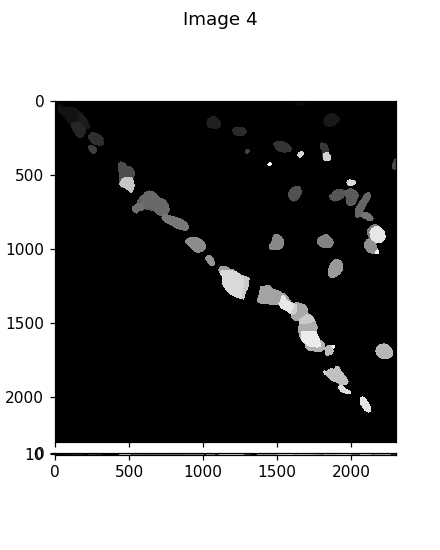

In [22]:
%matplotlib notebook
imshow_mark_3d([_dapi_im, _polyt_im, labels3d, corr_labels3d])

In [24]:
# Copy segmentation labels
data_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_data'
analysis_master_folder = r'/lab/weissman_imaging/puzheng/MERFISH_analysis'
print(os.listdir(data_master_folder))


['20230623-KPtumor_C2', '20231004-4T1F170_MF2', '20231230-4T1preEditTop8_MF4dna', '20240108-4T1F171_MF4', '20240117-msBrainP1_MF5']


In [28]:
experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
for _fd in os.listdir(data_master_folder):
    if experiment_date in _fd:
        break
analysis_folder = os.path.join(analysis_master_folder, _fd)
print(analysis_folder)

20240117
/lab/weissman_imaging/puzheng/MERFISH_analysis/20240117-msBrainP1_MF5


In [30]:
from shutil import copyfile

In [36]:
# manually select data to be transferred:
segmentation_target_folder = os.path.join(analysis_folder, 'CellPoseSegment', 'segmentation_label')
print(segmentation_target_folder)
if not os.path.exists(segmentation_target_folder):
    os.makedirs(segmentation_target_folder)
# copy
seg_label_filenames = [os.path.join(segmentation_save_folder, _f) 
                       for _f in os.listdir(segmentation_save_folder) 
                       if 'segmentation_label' in _f and '.npy' in _f]

for _f in seg_label_filenames:
    print(os.path.basename(_f))
    copyfile(_f, os.path.join(segmentation_target_folder, os.path.basename(_f)))

/lab/weissman_imaging/puzheng/MERFISH_analysis/20240117-msBrainP1_MF5/CellPoseSegment/segmentation_label
segmentation_label_0.npy
segmentation_label_1.npy
segmentation_label_2.npy
segmentation_label_3.npy
segmentation_label_4.npy
segmentation_label_5.npy
segmentation_label_6.npy
segmentation_label_7.npy
segmentation_label_8.npy
segmentation_label_9.npy
segmentation_label_10.npy
segmentation_label_11.npy
segmentation_label_12.npy
segmentation_label_13.npy
segmentation_label_14.npy
segmentation_label_15.npy
segmentation_label_16.npy
segmentation_label_17.npy
segmentation_label_18.npy
segmentation_label_19.npy
segmentation_label_20.npy
segmentation_label_21.npy
segmentation_label_22.npy
segmentation_label_23.npy
segmentation_label_24.npy
segmentation_label_25.npy
segmentation_label_26.npy
segmentation_label_27.npy
segmentation_label_28.npy
segmentation_label_29.npy
segmentation_label_30.npy
segmentation_label_31.npy
segmentation_label_32.npy
segmentation_label_33.npy
segmentation_label_34

In [34]:
len(seg_label_filenames)

291

In [35]:
?copyfile

# STEP2: Watershed: Optional, potentially make it worse

In [11]:
watershed_th = 1.6

for _fov_id, _fov_name in enumerate(fovs):
    

    _save_id = _fov_id 
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    ref_image_file = os.path.join(data_folder, dapi_info['hyb'], _fov_name)
    polyt_image_file = os.path.join(data_folder, polyt_info['hyb'], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = DaxProcesser(ref_image_file, CorrectionFolder=correction_folder, 
                            FiducialChannel=fiducial_channel, DapiChannel=dapi_info['channel'])
    _ref_cls._load_image(sel_channels=[fiducial_channel,dapi_info['channel']])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = DaxProcesser(polyt_image_file, CorrectionFolder=correction_folder, 
                        FiducialChannel=fiducial_channel)
    _cls._load_image(sel_channels=[polyt_info['channel'],fiducial_channel])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._corr_warpping_drift_chromatic(correction_channels=[polyt_info['channel']], corr_chromatic=False) # removed 405 to increase efficiency
    # extract images
    _dapi_im = copy(getattr(_ref_cls, f"im_{dapi_info['channel']}"))
    _polyt_im = copy(getattr(_cls, f"im_{polyt_info['channel']}"))
    
    
    _save_id = _fov_id 

    dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_dapi_im, microscope_params)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_polyt_im, microscope_params)

    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, watershed_th)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    #np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    break

- directly load seg from: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\Segmentation\segmentation_label_0.npy
reference image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
PolyT and DAPI image: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H19R1\Conv_zscan_000.dax
Initialize DaxProcesser for file:\\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000.dax
- New save file: \\wi-bigdata.wi.mit.edu\weissman_imaging\puzheng\msBrain\20230513-wtBrain_MO4_MERFISH_s\H0M1\Conv_zscan_000_processed.hdf5
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488', '405'] in 1.732s.
- Correct illumination for channels: ['488', '405']
-- Keep channels: ['488', '405'] for corr_illumination.
- Start illumination correction for channels:[

<IPython.core.display.Javascript object>


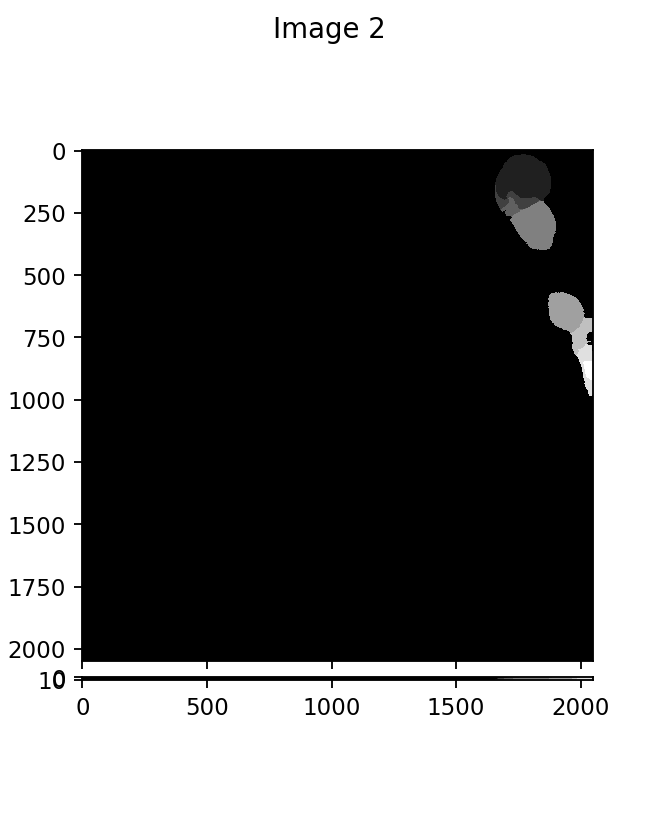

In [203]:
imshow_mark_3d([new_labels, corr_labels3d])

## visualize merlin_output_tif

In [12]:
import tifffile
ims = tifffile.imread(r'Z:\MERFISH_analysis\20230513-wtBrain_MO4\FiducialCorrelationWarp\images\aligned_fiducial_images30.tif')